# Import Libraries

In [2]:
# Import necessary libraries
import csv
import argparse
import os
import numpy as np
import pandas as pd
from time import time
from collections import deque
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from GraphTsetlinMachine.graphs import Graphs
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine

# Load Data Function

In [9]:
def load_data(input_file, sample_fraction=1, max_rows=None):
    X_data = []
    Y_data = []

    # Read the CSV file, limiting rows to `max_rows` if specified
    if max_rows:
        data = pd.read_csv(input_file, header=0, dtype=str, nrows=max_rows)
    else:
        data = pd.read_csv(input_file, header=0, dtype=str)

    # Sample a fraction of the data if specified
    data_sampled = data.sample(frac=sample_fraction, random_state=42)

    for _, row in tqdm(data_sampled.iterrows(), total=len(data_sampled), desc="Processing Rows"):
        try:
            board = row.iloc[:board_size * board_size].values.astype(int).reshape(board_size, board_size)
            label_raw = int(row.iloc[board_size * board_size])
            label = 1 if label_raw == 1 else 0 if label_raw == -1 else None
            if label is None:
                continue
        except ValueError:
            continue

        X_data.append(board)
        Y_data.append(label)

    return np.array(X_data), np.array(Y_data, dtype=np.int32)


# Argument Parser Setup

In [16]:
def setup_default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=20, type=int)
    parser.add_argument("--number-of-clauses", default=20000, type=int)
    parser.add_argument("--T", default=12000, type=int)
    parser.add_argument("--s", default=1, type=float)
    parser.add_argument("--depth", default=2, type=int)
    parser.add_argument("--hypervector-size", default=64, type=int)
    parser.add_argument("--hypervector-bits", default=2, type=int)
    parser.add_argument("--message-size", default=64, type=int)
    parser.add_argument("--message-bits", default=2, type=int)
    parser.add_argument('--double-hashing', dest='double_hashing', default=False, action='store_true')
    parser.add_argument("--max-included-literals", default=32, type=int)
    args, _ = parser.parse_known_args()
    for key, value in kwargs.items():
        if key in args.__dict__:
            setattr(args, key, value)

    return args

# Initialize parameters
board_size = 7  # Example board size
dim = board_size


# Define symbols


In [17]:
cell_symbols = ['empty', 'blue', 'red']
row_symbols = [f'row_{i}' for i in range(dim)]
col_symbols = [f'col_{j}' for j in range(dim)]
neighbor_symbols = [f'nbr_{symbol}_{count}' for symbol in cell_symbols for count in range(7)]
chain_symbols = ['chain_of_3_true', 'chain_of_3_false']
diagonal_symbols = ['diagonal_pair_true', 'diagonal_pair_false']
edge_symbols = ['near_top_edge', 'near_bottom_edge', 'near_left_edge', 'near_right_edge']
cluster_size_symbols = [f'cluster_size_{i}' for i in range(dim * dim + 1)]

# Combine all symbols
symbols = (
    cell_symbols +
    row_symbols +
    col_symbols +
    neighbor_symbols +
    chain_symbols +
    diagonal_symbols +
    edge_symbols +
    cluster_size_symbols
)

# Map cell values to symbols
value_to_symbol = {
    0: 'empty',
    -1: 'blue',
    1: 'red'
}


# Create Graphs Function


In [18]:
# Create training graphs
def create_graphs(X_data, is_training=True):
    graphs = Graphs(
        X_data.shape[0],
        symbols=symbols,
        hypervector_size=args.hypervector_size,
        hypervector_bits=args.hypervector_bits,
        double_hashing=args.double_hashing,
        init_with=None if is_training else graphs_train
    )

    number_of_nodes = dim * dim  # Total number of nodes per graph

    for graph_id in range(X_data.shape[0]):
        graphs.set_number_of_graph_nodes(graph_id, number_of_nodes)

    graphs.prepare_node_configuration()

    # Add a dictionary to store feature importance
    feature_importance = {}
    for symbol in symbols:
        feature_importance[symbol] = 0

    for graph_id in tqdm(range(X_data.shape[0]), desc="Creating nodes and adding features"):
        for q in range(dim):
            for r in range(dim):
                node_id = q * dim + r
                value = X_data[graph_id][q][r]
                cell_symbol = value_to_symbol[value]

                valid_neighbors = get_valid_neighbors(q, r, dim)
                neighbor_counts = {symbol: 0 for symbol in cell_symbols}
                for nq, nr in valid_neighbors:
                    neighbor_value = X_data[graph_id][nq][nr]
                    neighbor_symbol = value_to_symbol[neighbor_value]
                    neighbor_counts[neighbor_symbol] += 1

                cluster_size = calculate_cluster_size(q, r, cell_symbol, graph_id, set())
                edge_properties = check_edge_proximity(q, r)

                graphs.add_graph_node(graph_id, node_id, number_of_graph_node_edges=len(valid_neighbors))
                graphs.add_graph_node_property(graph_id, node_id, cell_symbol)
                graphs.add_graph_node_property(graph_id, node_id, f'row_{q}')
                graphs.add_graph_node_property(graph_id, node_id, f'col_{r}')

                for symbol, count in neighbor_counts.items():
                    graphs.add_graph_node_property(graph_id, node_id, f'nbr_{symbol}_{count}')

                graphs.add_graph_node_property(graph_id, node_id, f'cluster_size_{cluster_size}')
                for edge_property in edge_properties:
                    graphs.add_graph_node_property(graph_id, node_id, edge_property)

                # Update feature importance
                for symbol in [cell_symbol, f'row_{q}', f'col_{r}'] + [f'nbr_{symbol}_{count}' for symbol, count in neighbor_counts.items()] + [f'cluster_size_{cluster_size}'] + edge_properties:
                    feature_importance[symbol] += 1

    graphs.prepare_edge_configuration()
    add_edges(graphs, X_data)

    graphs.encode()
    return graphs, feature_importance

 # Helper functions


In [19]:
def add_edges(graphs, X_data):
    for graph_id in tqdm(range(X_data.shape[0]), desc="Adding edges"):
        for q in range(dim):
            for r in range(dim):
                node_id = q * dim + r
                for nq, nr in get_valid_neighbors(q, r, dim):
                    neighbor_node_id = nq * dim + nr
                    graphs.add_graph_node_edge(graph_id, node_id, neighbor_node_id, "Neighbor")

def get_valid_neighbors(q, r, dim):
    return [
        (nq, nr) for nq, nr in [
            (q - 1, r), (q + 1, r), (q, r - 1), (q, r + 1)
        ] if 0 <= nq < dim and 0 <= nr < dim
    ]

def calculate_cluster_size(q, r, symbol, graph_id, visited):
    stack = [(q, r)]
    visited.add((q, r))
    size = 1

    while stack:
        cq, cr = stack.pop()
        for nq, nr in get_valid_neighbors(cq, cr, dim):
            if (nq, nr) not in visited:
                neighbor_value = X_data[graph_id][nq][nr]
                neighbor_symbol = value_to_symbol[neighbor_value]
                if neighbor_symbol == symbol:
                    visited.add((nq, nr))
                    stack.append((nq, nr))
                    size += 1
    return size

def check_edge_proximity(q, r):
    properties = []
    if q == 0: properties.append('near_top_edge')
    if q == dim - 1: properties.append('near_bottom_edge')
    if r == 0: properties.append('near_left_edge')
    if r == dim - 1: properties.append('near_right_edge')
    return properties

# Main execution 


Adding edges: 100%|██████████| 20000/20000 [00:47<00:00, 417.64it/s]


Initialization of sparse structure.
Epoch 1: Train Accuracy: 82.68%, Test Accuracy: 80.92%, Time: 254.34s
Epoch 2: Train Accuracy: 84.64%, Test Accuracy: 82.17%, Time: 339.05s
Epoch 3: Train Accuracy: 85.12%, Test Accuracy: 82.25%, Time: 332.10s
Epoch 4: Train Accuracy: 79.35%, Test Accuracy: 77.06%, Time: 330.31s
Epoch 5: Train Accuracy: 81.36%, Test Accuracy: 78.58%, Time: 331.81s
Epoch 6: Train Accuracy: 82.45%, Test Accuracy: 79.35%, Time: 330.85s
Epoch 7: Train Accuracy: 84.68%, Test Accuracy: 80.88%, Time: 267.66s
Epoch 8: Train Accuracy: 85.64%, Test Accuracy: 81.62%, Time: 163.63s
Epoch 9: Train Accuracy: 88.46%, Test Accuracy: 83.39%, Time: 159.44s
Epoch 10: Train Accuracy: 87.60%, Test Accuracy: 82.67%, Time: 159.41s
Epoch 11: Train Accuracy: 88.47%, Test Accuracy: 83.21%, Time: 159.33s
Epoch 12: Train Accuracy: 88.62%, Test Accuracy: 82.91%, Time: 159.30s
Epoch 13: Train Accuracy: 88.89%, Test Accuracy: 83.23%, Time: 159.24s
Epoch 14: Train Accuracy: 89.19%, Test Accuracy: 8

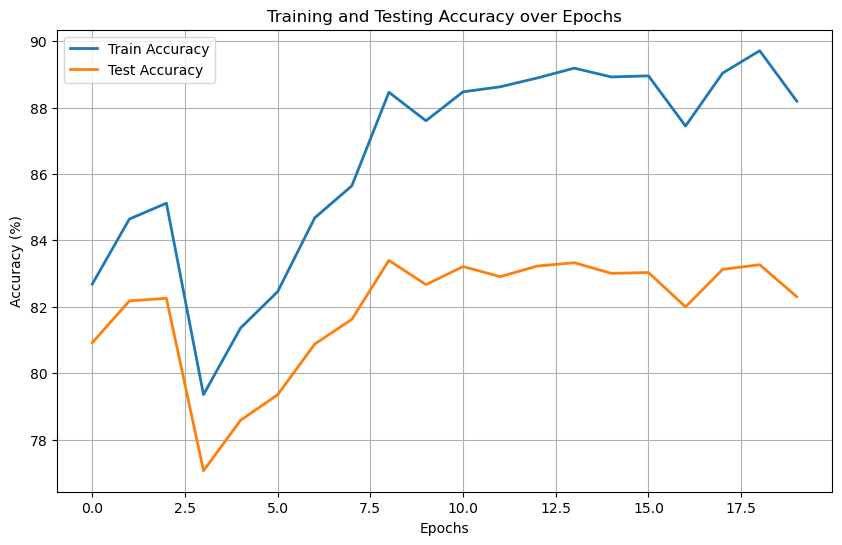

In [20]:
if __name__ == "__main__":
    args = setup_default_args()
    X_data, Y_data = load_data("hex_games_1_000_000_size_7.csv", max_rows=100000)
    X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

    # Create training and testing graphs
    graphs_train, feature_importance_train = create_graphs(X_train, is_training=True)
    graphs_test, feature_importance_test = create_graphs(X_test, is_training=False)

    # Tsetlin Machine setup
    tm = MultiClassGraphTsetlinMachine(
        number_of_clauses=args.number_of_clauses,
        T=args.T,
        s=args.s,
        depth=args.depth,
        max_included_literals=args.max_included_literals,
        message_size=args.message_size,
        message_bits=args.message_bits,
    )

    # Training loop with feedback and feature analysis
    train_accuracies, test_accuracies = [], []
    clause_activations = []

    for epoch in range(args.epochs):
        start_training = time()
        tm.fit(graphs_train, Y_train, epochs=1, incremental=True)
        end_training = time()

        train_accuracy = 100 * (tm.predict(graphs_train) == Y_train).mean()
        test_accuracy = 100 * (tm.predict(graphs_test) == Y_test).mean()
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Clause and feature analysis
        if hasattr(tm, 'get_clause_activity'):
            clause_activity = tm.get_clause_activity()
            clause_activations.append(clause_activity)

        print(f"Epoch {epoch + 1}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%, Time: {end_training - start_training:.2f}s")

    # Accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_accuracies)), train_accuracies, label="Train Accuracy", linewidth=2)
    plt.plot(range(len(test_accuracies)), test_accuracies, label="Test Accuracy", linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Testing Accuracy over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.pdf", format="pdf")
    plt.show()


    # Optional: Save clause activations for further analysis
    np.save("clause_activations.npy", clause_activations)


# Sort the feature importance dictionary in descending order


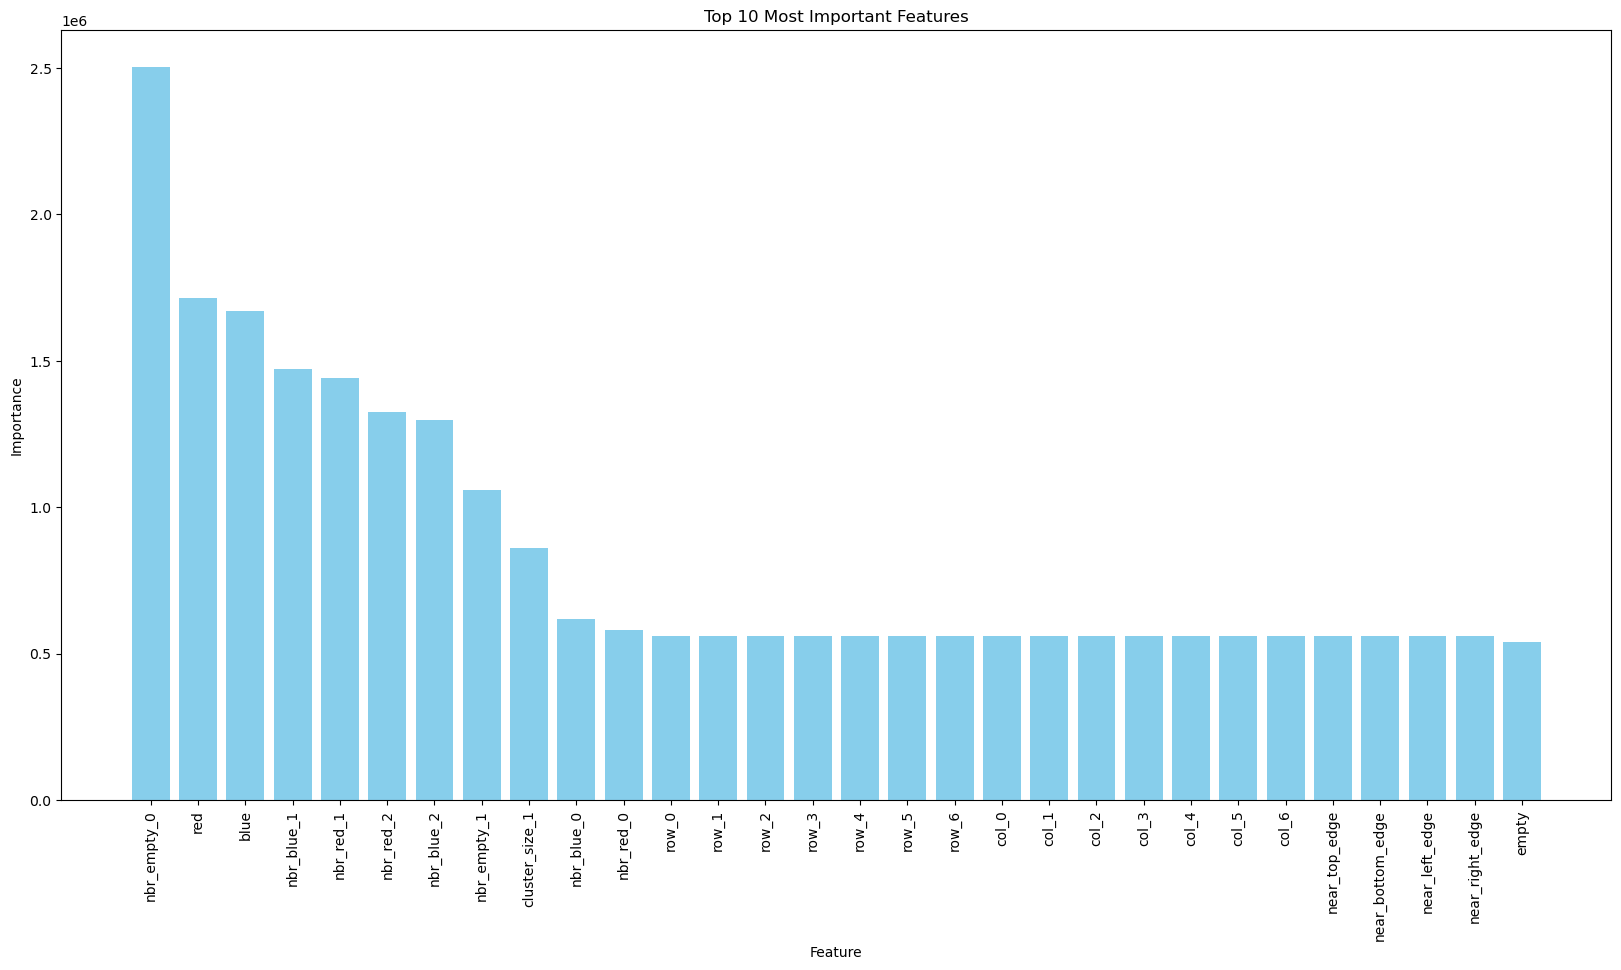

In [21]:
sorted_feature_importance = sorted(feature_importance_train.items(), key=lambda x: x[1], reverse=True)

# Extract the top 30 features and their importance values
top_features = [feature[0] for feature in sorted_feature_importance[:30]]
top_importance = [feature[1] for feature in sorted_feature_importance[:30]]

# Create plot
plt.figure(figsize=(20, 10))
plt.bar(range(len(top_features)), top_importance, color='skyblue')
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')
plt.savefig("top_feature_importance.pdf", format="pdf")
plt.show()

In [22]:
print(top_features)

['nbr_empty_0', 'red', 'blue', 'nbr_blue_1', 'nbr_red_1', 'nbr_red_2', 'nbr_blue_2', 'nbr_empty_1', 'cluster_size_1', 'nbr_blue_0', 'nbr_red_0', 'row_0', 'row_1', 'row_2', 'row_3', 'row_4', 'row_5', 'row_6', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'near_top_edge', 'near_bottom_edge', 'near_left_edge', 'near_right_edge', 'empty']
